In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
ed.set_seed(12)

In [5]:
N = 100   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.

# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])

# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
b = Normal(loc=tf.zeros(K), scale=tf.ones(K))

# Categorical likelihood for classication.
y = Categorical(tf.matmul(x,w)+b)

    - likelihood : P(y|x;w) 
    - prior prob : P(w) 
    - posterior  : P(w|y,x) ~ p(y|x,w)*p(w)
    - P(y)를 다루기 어렵기 때문에 posterioir 바로 구하지 않는다

### 위와 같은 문제를 해결하기위해 Variational Inference(VI)를 사용

    VI에서 매개변수 w에 대해 매개변수화된 분포 Q(w;lambda)의 family를 선택하여 
    true posterioir 그리고 가능한 true posterior에 match하도록 lambda를 최적화


### Kullback-Leibler divergenc(KL-divergence)
 - true posterior P(w|y,x) 와 approximating distribution Q(w;lambda)
 - 두 확률 분포의 차이를 계산 (KL-divergence를 줄이는 것이 두 확률분포를 비슷하게 만드는 것)

In [7]:
# 근사한 확률 분표 Q
qw = Normal(loc=tf.Variable(tf.random_normal([D, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qb = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
# log(1+exp(x)) = softplus

In [8]:
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])

# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({w: qw, b: qb}, data={y:y_ph})

In [9]:
# Initialse the infernce variables
inference.initialize(n_iter=5000, n_print=100, scale={y: float(mnist.train.num_examples) / N})

### VI (inference)를 실행해보자

In [10]:
# We will use an interactive session.
sess = tf.InteractiveSession()

# Initialise all the vairables in the session.
tf.global_variables_initializer().run()

In [11]:
# Let the training begin. We load the data in minibatches and update the VI infernce using each new batch.
for _ in range(inference.n_iter):
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1) # one-hot을 index로 바꿈
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
    inference.print_progress(info_dict)

5000/5000 [100%] ██████████████████████████████ Elapsed: 8s | Loss: 23504.553


## evaluate model 
- 모델을 평가하기위해 사용하는 파라미터(w,b)에 대한 single value가 없다
- 대신, 우리 모델에서의 파라미터의 분포를 가지고 매개변수 uncertainty를 최종 예측에 반영해야함
- single 예측이 아닌 일련의 예측,정확도를 얻음

In [12]:
# Load the test images.
X_test = mnist.test.images
# TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
Y_test = np.argmax(mnist.test.labels,axis=1)

# Generate samples the posterior and store them.
n_samples = 10
prob_lst = []
samples = []
w_samples = []
b_samples = []
for _ in range(n_samples):
    w_samp = qw.sample() # w의 분포에서 sampling
    b_samp = qb.sample() # b의 분포에서 sampling
    w_samples.append(w_samp)
    b_samples.append(b_samp)
    
    # Also compue the probabiliy of
    # each class for each (w,b) sample.
    prob = tf.nn.softmax(tf.matmul( X_test,w_samp ) + b_samp) # 최종 예측에 반영
    prob_lst.append(prob.eval()) # p(y|x,w)*p(w)
    
    sample = tf.concat([tf.reshape(w_samp,[-1]),b_samp],0)
    samples.append(sample.eval())

Text(0,0.5,'Frequency')

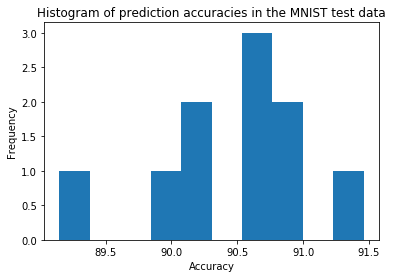

In [13]:
# Compute the accuracy of the model. 
# For each sample we compute the predicted class and compare with the test labels.
# Predicted class is defined as the one which as maximum proability.
# We perform this test for each (w,b) in the posterior giving us a set of accuracies
# Finally we make a histogram of accuracies for the test data.

accy_test = []
for prob in prob_lst: # 최종 예측 list
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == Y_test).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")

- 통계적으로 가능한 가중치 및 편향 범위에서 오는 Uncertainty

- 사후확률분포에서 가져온 100개의 샘플의 예측을 평균해서 구함

In [14]:
# Here we compute the mean of probabilties for each class for all the (w,b) samples.
# We then use the class with maximum of the mean proabilities as the prediction. 
# In other words, we have used (w,b) samples to construct a set of models and
# used their combined outputs to make the predcitions.
Y_pred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
print("accuracy in predicting the test data = ", (Y_pred == Y_test).mean()*100)

accuracy in predicting the test data =  92.15


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


Text(0.5,0.98,'Joint posterior distribution of the first 5 weights')

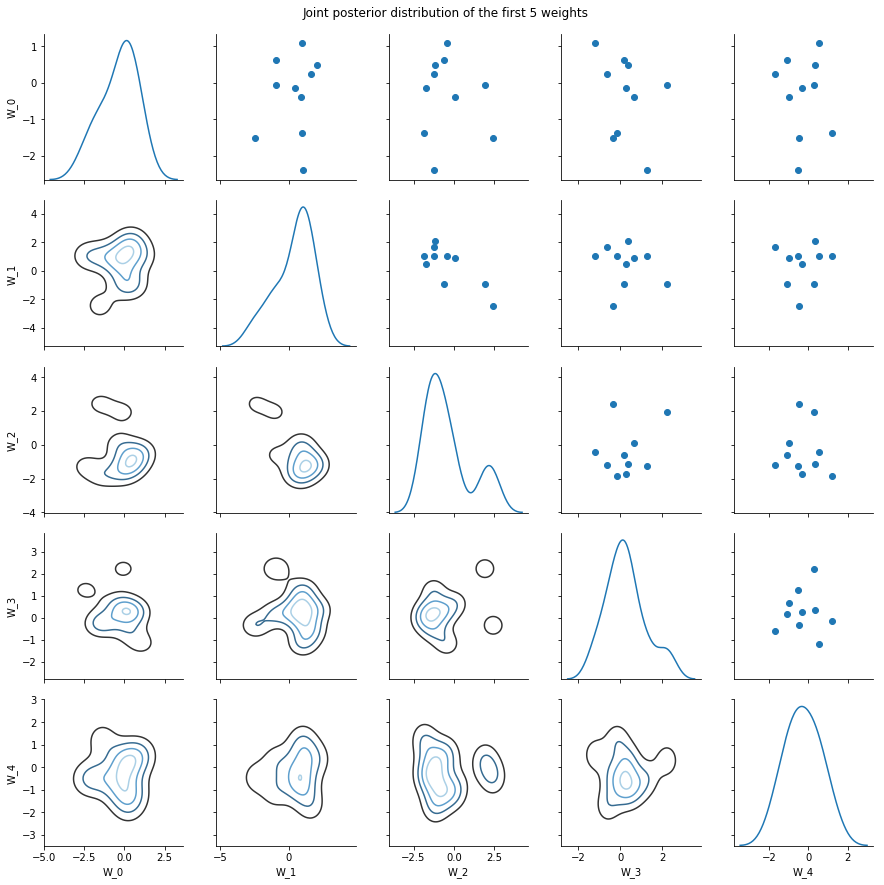

In [21]:
# posterior samples.
samples_df = pd.DataFrame(data = samples, index=range(n_samples))
# 5개만 뽑아서
samples_5 = pd.DataFrame(data = samples_df[list(range(5))].values,columns=["W_0", "W_1", "W_2", "W_3", "W_4"])

g = sns.PairGrid(samples_5, diag_sharey=False)
g.map_lower(sns.kdeplot, n_levels = 4,cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot,legend=False)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Joint posterior distribution of the first 5 weights')

truth =  7


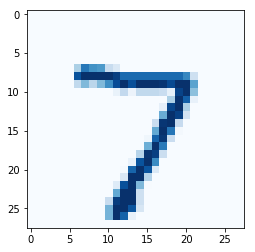

In [22]:
# Load the first image from the test data and its label.
test_image = X_test[0:1]
test_label = Y_test[0]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='Blues')

Text(0,0.5,'Frequency')

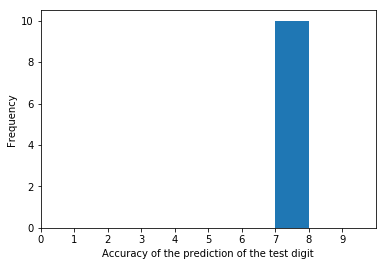

In [23]:
# 우리가 샘플링한 10개의 사후분포 가중치로 예측
# Now the check what the model perdicts for each (w,b) sample from the posterior. This may take a few seconds...
sing_img_probs = []
for w_samp,b_samp in zip(w_samples,b_samples):
    prob = tf.nn.softmax(tf.matmul( X_test[0:1],w_samp ) + b_samp)
    sing_img_probs.append(prob.eval())
    
# Create a histogram of these predictions.
plt.hist(np.argmax(sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test digit")
plt.ylabel("Frequency")

### 모델이 모르는 데이터(unfamiliar data)는 어떻게 처리?

mnist가 아닌데 비슷한 데이터를 가져왔다(not_mnist)

In [29]:
not_mnist  =  input_data . read_data_sets ( "./notMNIST_data/" ,  one_hot = True )

Extracting ./notMNIST_data/train-images-idx3-ubyte.gz
Extracting ./notMNIST_data/train-labels-idx1-ubyte.gz
Extracting ./notMNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./notMNIST_data/t10k-labels-idx1-ubyte.gz


In [36]:
not_mnist

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1cf8638630>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1cf8638c50>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1cf8638cc0>)

In [30]:
# Load the test images from the data and their lables. 
Xnm_test = not_mnist.test.images
# Once again convert one-hot-vector to the corresponding labels.
Ynm_test = np.argmax(not_mnist.test.labels,axis=1)

truth =  7


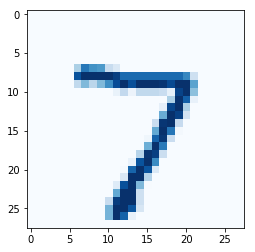

In [33]:
# Load the first image from the notMNIST.
test_image2 = Xnm_test[0]
test_label2 = Ynm_test[0]
print('truth = ',test_label2)
pixels = test_image2.reshape((28, 28))
plt.imshow(pixels,cmap='Blues')
#????not mnist인데......

In [27]:
# As before, compute the proabilities for each class for all (w,b) samples from the posterior.
nm_sing_img_probs = []
for w_samp,b_samp in zip(w_samples,b_samples):
    prob = tf.nn.softmax(tf.matmul( Xnm_test[0:1],w_samp ) + b_samp)
    nm_sing_img_probs.append(prob.eval())

Text(0,0.5,'Frequency')

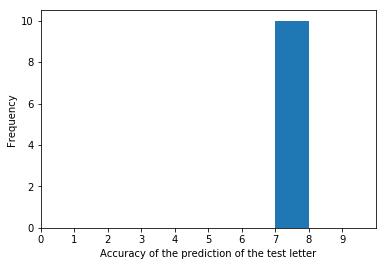

In [28]:
# Now compute the histogram of perdictions from the (w,b) samples.
# In our previous test, all the weights from the posterior was able get the correct prediction.
# However, here we see that the model gives a wide range of possibilites.
# Hence we conclude that its cofidence is lower. 
plt.hist(np.argmax(nm_sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test letter")
plt.ylabel("Frequency")